In [1]:
# https://github.com/MicrosoftDocs/pytorchfundamentals/blob/main/computer-vision-pytorch/pytorchcv.py
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

# torchinfo: https://github.com/TylerYep/torchinfo
!pip install torchinfo

--2021-07-17 18:51:08--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6371 (6.2K) [text/plain]
Saving to: ‘pytorchcv.py’

pytorchcv.py        100%[===================>]   6.22K  --.-KB/s    in 0s      

2021-07-17 18:51:08 (81.1 MB/s) - ‘pytorchcv.py’ saved [6371/6371]



In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import os

from pytorchcv import train, plot_results, display_dataset, train_long, check_image_dir

In [3]:
if not os.path.exists("data/kagglecatsanddogs_3367a.zip"):  # exists: Test whether a path exists. Returns False for broken symbolic links
    !wget -P data -q https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
    # -P: directory prefix (where files will be saved);  # -q: quiet (no output)

In [4]:
import zipfile
if not os.path.exists("data/PetImages"):
    with zipfile.ZipFile("data/kagglecatsanddogs_3367a.zip", 'r') as zip_ref:  # ZipFile: class for reading and writing ZIP files. mode='r': to read an existing file
        zip_ref.extractall("data")  # 先將壓縮檔使用 zipfile 讀取，並使用 extractall() 函式解壓縮

In [5]:
check_image_dir("data/PetImages/Cat/*.jpg")
check_image_dir("data/PetImages/Dog/*.jpg")

# what pytorchcv.check_image_dir does is:
#
# from PIL import Image
# import glob
# 
# def check_image(fn):
#     try:
#         im = Image.open(fn)
#         im.verify()  # verify(): determine if the file is broken. If broken, raise exception
#         return True
#     except:
#         return False
# 
# def check_image_dir(path):
#     for fn in glob.glob(path):  # glob(): Return a possibly-empty list of path names that match pathname
#         if not check_image(fn):
#             print("Corrupt image: {}".format(fn))
#             os.remove(fn)  # remove file

Corrupt image: data/PetImages/Cat/666.jpg
Corrupt image: data/PetImages/Dog/11702.jpg


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

In [6]:
# Dealing with following two warning when reading PIL image:
#     UserWarning: Possibly corrupt EXIF data.
#     UserWarning: Corrupt EXIF data
# This is because some of the images have corrupted exif info. We won't need it. Can ignore
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=r'.*EXIF.*')  # message is in regular expression; .* will match the whole string befor/after EXIF

Total numbers of samples in cleaned dataset: 24998


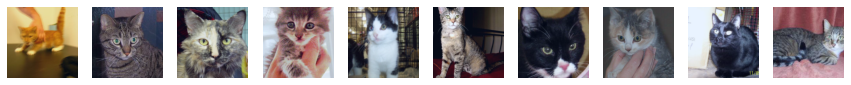

In [7]:
std_normalize = transforms.Normalize(  # Normalize: Normalize a tensor image with mean and standard deviation.
    mean=[0.485, 0.456, 0.406], # mean and std of ImageNet
    std=[0.229, 0.224, 0.225]
)

trans = transforms.Compose([
    transforms.Resize(size=256),  # If size is an int, smaller edge of the image will be matched to this number.
    transforms.CenterCrop(224),  # If image size is smaller than output size along any edge, image is padded with 0 and then center cropped.
    transforms.ToTensor(),
    std_normalize
])

dataset = torchvision.datasets.ImageFolder(root="data/PetImages", transform=trans)  # ImageFolder: images are arranged in root/[class]/[...]/image0
trainset, testset = torch.utils.data.random_split(dataset=dataset, lengths=[20000, len(dataset) - 20000])  # Randomly split a dataset into non-overlapping new datasets of given lengths. But no guarantee to return balanced data
                                                                                                           # if needing strictly the same distribution: create the training and testing indices with "sklearn.model_selection.train_test_split" and pass the target array to "stratify" argument. The returned train and test indices can then be used in Subset to create the datasets.
display_dataset(dataset)
print(f"Total numbers of samples in cleaned dataset: {len(dataset)}")

In [8]:
vgg = torchvision.models.vgg16(pretrained=True)  # pretrained on ImageNet
sample_image = dataset[0][0].unsqueeze(0)  # Returns a new tensor with a dimension of one more size inserted at the specified position
res = vgg(sample_image)  # res: size([N, Total_Class])
print(res[0].argmax())

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor(282)


In [9]:
import json, requests  # requests.get(): return a "Response" object from a webpage, can get all the information needed from this object  # .text: read the content of the server’s response, return a string
class_map = json.loads(requests.get("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json").text)  # json.load(fp): deserialize fp (a str, bytes or bytearray instance containing a JSON document) to a Python object. return a dict
class_map = {int(k): v for k, v in class_map.items()}  # When looping through dictionaries, the key and corresponding value can be retrieved at the same time using the items() method
class_map[res[0].argmax().item()]

['n02123159', 'tiger_cat']

In [10]:
summary(vgg, input_size=(1, 3, 224, 224))  # nn.AdaptiveAvgPool2d(output_size): The output is of size H x W, for any input size

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Doing computations on device = {device}")

vgg.to(device)
sample_image = sample_image.to(device)

vgg(sample_image).argmax()

Doing computations on device = cuda


tensor(281, device='cuda:0')

torch.Size([1, 512, 7, 7])
<class 'torch.Tensor'> tensor(0.) tensor(27.2867)


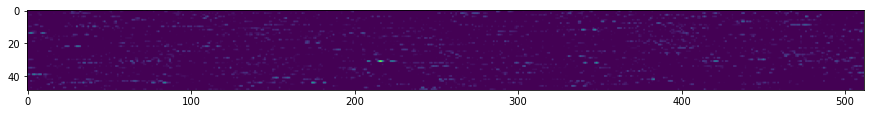

In [12]:
res = vgg.features(sample_image).cpu()
plt.figure(figsize=(15, 3))             # imshow(): By default, a linear scaling mapping the lowest value to 0 and the highest to 1 is used, before mapping to colors using cmap
plt.imshow(res.detach().view(-1, 512))  # imshow(): Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead. (tensor.detach() is OK either)
print(res.size())
print(type(res.detach()), res.detach().min(), res.detach().max())

In [13]:
bs = 8
dl = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
num = bs * 100
feature_tensor = torch.zeros(num, 512 * 7 * 7).to(device)
label_tensor = torch.zeros(num).to(device)  # zeros(): The default dtype is torch.float (=torch.float32).
i = 0
for x, l in dl:
    with torch.no_grad():
        f = vgg.features(x.to(device))
        feature_tensor[i: i + bs] = f.view(bs, -1)  # can assign as long as non-singleton dimension match
        label_tensor[i: i + bs] = l
        i += bs
        print('.', end='')  # end: string appended after the last value, default a newline (\n).
        if i >= num:
            break

....................................................................................................

In [14]:
label_tensor[0].dtype

torch.float32

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch  0, Train acc=0.926, Val acc=0.940, Train loss=0.032, Val loss=0.017
Epoch  1, Train acc=0.990, Val acc=0.970, Train loss=0.003, Val loss=0.033
Epoch  2, Train acc=0.999, Val acc=0.950, Train loss=0.002, Val loss=0.052
Epoch  3, Train acc=0.996, Val acc=0.960, Train loss=0.003, Val loss=0.027
Epoch  4, Train acc=0.999, Val acc=0.960, Train loss=0.000, Val loss=0.024
Epoch  5, Train acc=0.999, Val acc=0.960, Train loss=0.001, Val loss=0.046
Epoch  6, Train acc=1.000, Val acc=0.950, Train loss=0.000, Val loss=0.052
Epoch  7, Train acc=1.000, Val acc=0.950, Train loss=0.000, Val loss=0.052
Epoch  8, Train acc=1.000, Val acc=0.950, Train loss=0.000, Val loss=0.052
Epoch  9, Train acc=1.000, Val acc=0.950, Train loss=0.000, Val loss=0.052


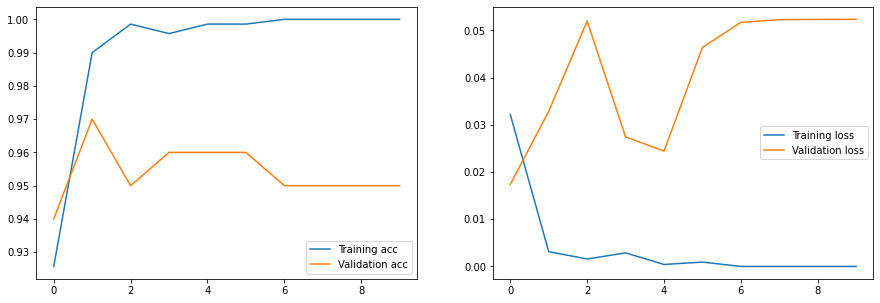

In [15]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor, label_tensor.to(torch.long))  # TensorDataset(*tensors): Each sample will be retrieved by indexing tensors along the first dimension. *tensors: input tensors that have the same size of the first dimension.  # torch.long=torch.int64
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset, lengths=[700, 100])

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32)

net = torch.nn.Sequential(torch.nn.Linear(512 * 7 * 7, 2), torch.nn.LogSoftmax()).to(device)

history = train(net, train_loader, test_loader)

plot_results(history)

In [16]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
vgg.classifier = torch.nn.Linear(25088, 2).to(device)  # need .to(device) explicitly, because weights in a module are allowed to be on different devices, and here we add new weights (default on cpu) after vgg.to(device)

for x in vgg.features.parameters():  # can get the parameters of each class member
    x.requires_grad = False  # vgg.avgpool is not trainable, no need to freeze it

summary(vgg, input_size=(1, 3, 244, 244))  # Trainable params will consider only the ones with requires_grad=True

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 244, 244]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 244, 244]         --
│    └─Conv2d: 2-3                       [1, 64, 244, 244]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 244, 244]         --
│    └─MaxPool2d: 2-5                    [1, 64, 122, 122]         --
│    └─Conv2d: 2-6                       [1, 128, 122, 122]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 122, 122]        --
│    └─Conv2d: 2-8                       [1, 128, 122, 122]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 122, 122]        --
│    └─MaxPool2d: 2-10                   [1, 128, 61, 61]          --
│    └─Conv2d: 2-11                      [1, 256, 61, 61]    

In [18]:
trainset, testset = torch.utils.data.random_split(dataset, lengths=[20000, len(dataset) - 20000])
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16)
test_loader = torch.utils.data.DataLoader(testset, batch_size=16)

train_long(vgg, train_loader, test_loader, loss_fn=torch.nn.CrossEntropyLoss(), epochs=1, print_freq=90)

# what torchcv.train_long does is:
#
# def validate(net, dataloader,loss_fn=nn.NLLLoss()):
#     net.eval()
#     count,acc,loss = 0,0,0
#     with torch.no_grad():
#         for features,labels in dataloader:
#             lbls = labels.to(default_device)
#             out = net(features.to(default_device))
#             loss += loss_fn(out,lbls) 
#             pred = torch.max(out,1)[1]  # torch.max() with dim arguement specified: return torch.return_types.max namedtuple (values, indices)
#             acc += (pred==lbls).sum()
#             count += len(labels)
#     return loss.item()/count, acc.item()/count
# 
# def train_long(net,train_loader,test_loader,epochs=5,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss(),print_freq=10):
#     optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
#     for epoch in range(epochs):
#         net.train()
#         total_loss,acc,count = 0,0,0
#         for i, (features,labels) in enumerate(train_loader):
#             lbls = labels.to(default_device)
#             optimizer.zero_grad()
#             out = net(features.to(default_device))
#             loss = loss_fn(out,lbls)
#             loss.backward()
#             optimizer.step()
#             total_loss+=loss
#             _,predicted = torch.max(out,1)
#             acc+=(predicted==lbls).sum()
#             count+=len(labels)
#             if i%print_freq==0:
#                 print("Epoch {}, minibatch {}: train acc = {}, train loss = {}".format(epoch,i,acc.item()/count,total_loss.item()/count))
#         vl,va = validate(net,test_loader,loss_fn)
#         print("Epoch {} done, validation acc = {}, validation loss = {}".format(epoch,va,vl))

Epoch 0, minibatch 0: train acc = 0.625, train loss = 0.04731190577149391
Epoch 0, minibatch 90: train acc = 0.9574175824175825, train loss = 0.0816023690359933
Epoch 0, minibatch 180: train acc = 0.9630524861878453, train loss = 0.10323860632121892
Epoch 0, minibatch 270: train acc = 0.966789667896679, train loss = 0.11196909267524072
Epoch 0, minibatch 360: train acc = 0.9665858725761773, train loss = 0.1367095461182317
Epoch 0, minibatch 450: train acc = 0.9689578713968958, train loss = 0.1379013822771229
Epoch 0, minibatch 540: train acc = 0.9695009242144177, train loss = 0.13887188923777583
Epoch 0, minibatch 630: train acc = 0.9700871632329635, train loss = 0.13924313649511563
Epoch 0, minibatch 720: train acc = 0.9714805825242718, train loss = 0.1368984587480225
Epoch 0, minibatch 810: train acc = 0.9726418002466092, train loss = 0.13516995468798165
Epoch 0, minibatch 900: train acc = 0.9723224195338512, train loss = 0.14763916557557574
Epoch 0, minibatch 990: train acc = 0.9733

Epoch 0, minibatch 0: train acc = 0.625, train loss = 0.04673381149768829
Epoch 0 done, validation acc = 0.5970388155262105, validation loss = 0.5859351553121248
Epoch 0, minibatch 90: train acc = 0.9553571428571429, train loss = 0.09059882949996781
Epoch 0 done, validation acc = 0.974389755902361, validation loss = 0.07219618804553071
Epoch 0, minibatch 180: train acc = 0.9623618784530387, train loss = 0.09362391477131712
Epoch 0 done, validation acc = 0.9655862344937975, validation loss = 0.12868440833364597
Epoch 0, minibatch 270: train acc = 0.9654059040590406, train loss = 0.10273675109187615
Epoch 0 done, validation acc = 0.9781912765106042, validation loss = 0.08825592614975677
Epoch 0, minibatch 360: train acc = 0.9652008310249307, train loss = 0.14052803694706545
Epoch 0 done, validation acc = 0.9795918367346939, validation loss = 0.09606840172592475
Epoch 0, minibatch 450: train acc = 0.966879157427938, train loss = 0.13618366892744854
Epoch 0 done, validation acc = 0.9757903

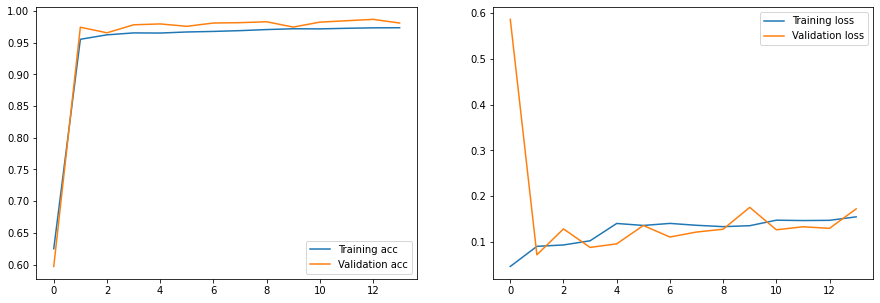

In [19]:
import pytorchcv

def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            lbls = labels.to(pytorchcv.default_device)  # In pytorchcv.py, default_device object didn't defined in builtins nor defined as a function/class. So even import pytorchcv, it still cannot directly be called by only the name "default_device"
            out = net(features.to(pytorchcv.default_device))
            loss += loss_fn(out,lbls) 
            pred = torch.max(out,1)[1]
            acc += (pred==lbls).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

def train_long(net,train_loader,test_loader,epochs=5,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss(),print_freq=10):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}  # add res to record history
    for epoch in range(epochs):
        net.train()
        total_loss,acc,count = 0,0,0
        for i, (features,labels) in enumerate(train_loader):
            lbls = labels.to(pytorchcv.default_device)
            optimizer.zero_grad()
            out = net(features.to(pytorchcv.default_device))
            loss = loss_fn(out,lbls)
            loss.backward()
            optimizer.step()
            total_loss+=loss
            _,predicted = torch.max(out,1)
            acc+=(predicted==lbls).sum()
            count+=len(labels)
            if i%print_freq==0:
                print("Epoch {}, minibatch {}: train acc = {}, train loss = {}".format(epoch,i,acc.item()/count,total_loss.item()/count))
                vl,va = validate(net,test_loader,loss_fn)  # validate every print_freq
                print("Epoch {} done, validation acc = {}, validation loss = {}".format(epoch,va,vl))  # validate every print_freq
                res['train_loss'].append(total_loss.item()/count)  # add res to record history
                res['train_acc'].append(acc.item()/count)  # add res to record history
                res['val_loss'].append(vl)  # add res to record history
                res['val_acc'].append(va)  # add res to record history
    return res
                

vgg = torchvision.models.vgg16(pretrained=True).to(device)

vgg.classifier = torch.nn.Linear(25088, 2).to(device)

for x in vgg.features.parameters():
    x.requires_grad = False

hist = train_long(vgg, train_loader, test_loader, loss_fn=torch.nn.CrossEntropyLoss(), epochs=1, print_freq=90)

plot_results(hist)

In [20]:
torch.save(vgg, "data/cats_dogs.pth")

In [21]:
vgg = torch.load("data/cats_dogs.pth")

In [22]:
for x in vgg.features.parameters():  # parameters(): Returns an iterator
    x.requires_grad = True

summary(vgg)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      590,080
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      1,180,160
│    └─ReLU: 2-19                

Epoch 0, minibatch 0: train acc = 1.0, train loss = 0.0
Epoch 0 done, validation acc = 0.98359343737495, validation loss = 0.14487297604588711
Epoch 0, minibatch 90: train acc = 0.9409340659340659, train loss = 0.21233860476986394
Epoch 0 done, validation acc = 0.951780712284914, validation loss = 0.060228437077956186
Epoch 0, minibatch 180: train acc = 0.9475138121546961, train loss = 0.1368231799721059
Epoch 0 done, validation acc = 0.9425770308123249, validation loss = 0.05877340560247536
Epoch 0, minibatch 270: train acc = 0.9471863468634686, train loss = 0.10368664590195097
Epoch 0 done, validation acc = 0.9717887154861945, validation loss = 0.024096345081001152
Epoch 0, minibatch 360: train acc = 0.9527354570637119, train loss = 0.08411322934475632
Epoch 0 done, validation acc = 0.9635854341736695, validation loss = 0.01946227251887083
Epoch 0, minibatch 450: train acc = 0.9549611973392461, train loss = 0.07052367436647944
Epoch 0 done, validation acc = 0.9645858343337335, valida

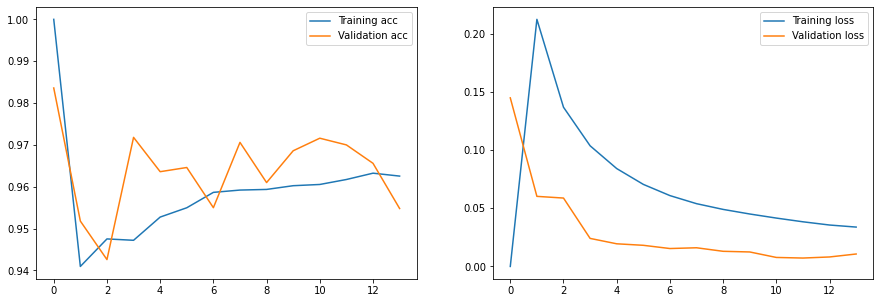

In [23]:
hist = train_long(vgg, train_loader, test_loader, loss_fn=torch.nn.CrossEntropyLoss(), epochs=1, print_freq=90, lr=0.0001)

plot_results(hist)

After unfreezing, we can do a few more epochs of training.

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      590,080
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      1,180,160
│    └─ReLU: 2-19                

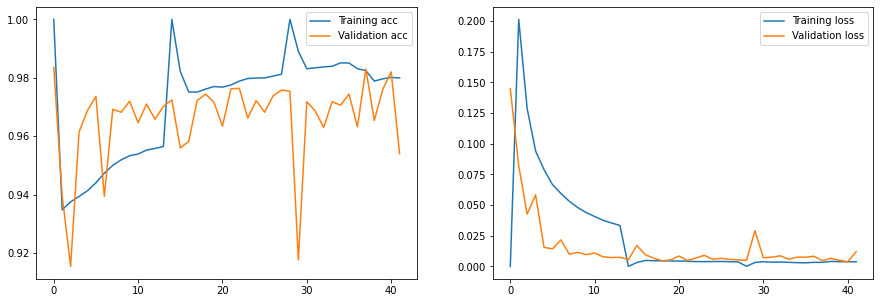

In [25]:
# more epochs=3
# same for the after experiments
vgg = torch.load("data/cats_dogs.pth")

for x in vgg.features.parameters():
    x.requires_grad = True

print(summary(vgg))

hist = train_long(vgg, train_loader, test_loader, loss_fn=torch.nn.CrossEntropyLoss(), epochs=3, print_freq=90, lr=0.0001)  # more epochs

plot_results(hist)

However, even with low learning rate, you can expect the accuracy to drop in the beginning of the training, until finally reaching slightly higher level than in the case of fixed weights.

In [26]:
# ??why accuracy drop first then up??
# Maybe, it was already in a closer point to local minima, but initiall the lr makes it step a little bit over the minima

 You can also select lower learning rate, in order to minimize the impact on the pre-trained weights.

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      590,080
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      1,180,160
│    └─ReLU: 2-19                

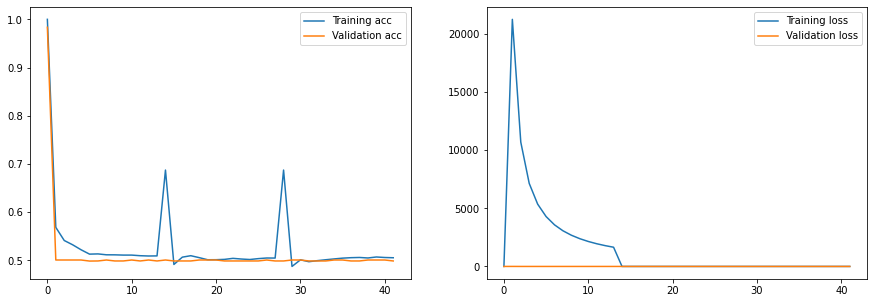

In [27]:
# ??what if lr is not smaller?? (with previously trained fc weights)
# initially much worser, maybe the higher learning rate makes it step too far over the original point closer to local minima (weights got impacted too much at first, can't save it by this small dataset even with longer epochs afterwards)
vgg = torch.load("data/cats_dogs.pth")

for x in vgg.features.parameters():
    x.requires_grad = True

print(summary(vgg))  # need to print the variable to show in jupyter notebook output if the variable is not at the last line of cell

hist = train_long(vgg, train_loader, test_loader, loss_fn=torch.nn.CrossEntropyLoss(), epochs=3, print_freq=90)  # larger (default) lr=0.01

plot_results(hist)

Note: It is important that you freeze parameters first and perform several epochs of training in order to stabilize weights in the classification layer. If you immediately start training end-to-end network with unfrozen parameters, large errors are likely to destroy the pre-trained weights in the convolutional layers.

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      590,080
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      1,180,160
│    └─ReLU: 2-19                

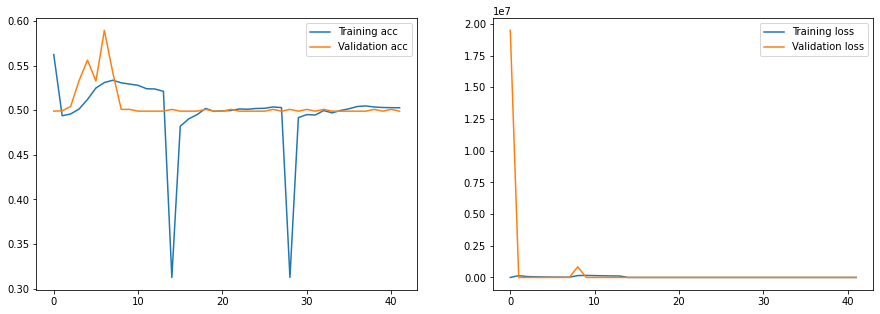

In [28]:
# ??What if pretrained weights of feature extractor aren't fixed, and directly train end-to-end whole network intead??
# initial large errors caused by wrong fc weight, will destroy the pre-trained weights in the convolutional layers in the first few steps, because of large updates caused by large total loss
vgg = torchvision.models.vgg16(pretrained=True)  # use pretrained weights for features extractor and didn't frozen them
vgg.to(device)
vgg.classifier = torch.nn.Linear(25088, 2).to(device)  # train random init classifier and pretrained-weight features extractor end-to-end directly

for x in vgg.features.parameters():
    x.requires_grad = True

print(summary(vgg))

hist = train_long(vgg, train_loader, test_loader, loss_fn=torch.nn.CrossEntropyLoss(), epochs=3, print_freq=90)  # larger (default) lr=0.01

plot_results(hist)

In [29]:
resnet = torchvision.models.resnet18()
print(resnet)
print(summary(resnet))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
# ??how batchnorm works during eval??